# Imports

In [0]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

%matplotlib inline

In [0]:
!rm -rf sample_data && mkdir data && mv *.csv data/ && mv *.pickle data/

## Model Parameters

In [0]:
cv = 5
method = 'Neural Network'
test_size = 0.2
random_state = 229

## Functions

In [0]:
# output performance metrics
def output_metrics(X_train, y_train, X_test, y_test, model, method, cv=5):
    print("{method} R-squared for train: %.4f".format(method=method) % (r2_score(y_train, model.predict(X_train))))
    print("{method} R-squared for CV: %.4f".format(method=method) % 
          (cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()))

    MSE_train = mean_squared_error(y_train, model.predict(X_train))
    MSE_CV = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    print("{method} MSE for train: %.4f".format(method=method) % (MSE_train))
    print("{method} MSE for CV: %.4f".format(method=method) % (MSE_CV))
    print("{method} MSE_CV/MSE_train: %.4f".format(method=method) % (MSE_CV/MSE_train))

    print()
    print("{method} R-squared for test: %.4f".format(method=method) % (r2_score(y_test, model.predict(X_test))))
    print("{method} MSE for test: %.4f".format(method=method) % (mean_squared_error(y_test, model.predict(X_test))))

In [0]:
# function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, figsize=(10, 7),
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=figsize, dpi=200, facecolor='w', edgecolor='k')
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R-2 score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Neural Network Implementation

In [6]:
df = pd.read_csv('data/df_52feat.csv', header=0, index_col=0)
df.head(3)

,PicCount,List Price,Sold Price,Tot BR,Tot Baths,TotFlArea,Age,TotalPrkng,# Rms,Fireplaces,...,District 12,District 25,District 4,District 32,District 5,District 23,District 19,District 2,DOM,Address_IsPH
R2050687,-2.302161,-0.861236,-0.914670,-0.657683,-0.807609,-0.862037,-0.520211,-0.127012,-1.111587,1.527118,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
R2050161,-2.643100,-0.344493,-0.385520,0.869434,0.947883,0.213822,-0.287701,-0.127012,0.155713,1.527118,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,1
R2049384,0.766285,-0.038619,0.480363,0.869434,0.947883,0.086644,0.099816,-0.127012,0.155713,1.527118,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0


In [0]:
not_features = ['List Price', 'Sold Price', 'DOM', 'Taxes/TotFlArea']

X = df.drop(not_features, axis=1)
y = df['Sold Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

## NN1: Milestone Network

In [0]:
def NN1():
    model = Sequential()
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    

def NN2():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def NN3():
    model = Sequential()
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def NN4():
    model = Sequential()
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',)
    return model


def NN5():
    model = Sequential()
    model.add(Dense(16))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))
    model.add(Dense(8))
    model.add(LeakyReLU(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def NN6():
    model = Sequential()
    model.add(Dense(64))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = NN5()

In [9]:
training = model.fit(X_train.values, y_train.values, epochs=50, batch_size=32, shuffle=True, verbose=2, validation_data=(X_test, y_test))

Train on 5446 samples, validate on 1362 samples
Epoch 1/50
 - 3s - loss: 0.5757 - val_loss: 0.2825
Epoch 2/50
 - 1s - loss: 0.2277 - val_loss: 0.2134
Epoch 3/50
 - 1s - loss: 0.1926 - val_loss: 0.1861
Epoch 4/50
 - 1s - loss: 0.1766 - val_loss: 0.1760
Epoch 5/50
 - 1s - loss: 0.1673 - val_loss: 0.1686
Epoch 6/50
 - 1s - loss: 0.1625 - val_loss: 0.1700
Epoch 7/50
 - 1s - loss: 0.1588 - val_loss: 0.1637
Epoch 8/50
 - 1s - loss: 0.1551 - val_loss: 0.1618
Epoch 9/50
 - 1s - loss: 0.1519 - val_loss: 0.1605
Epoch 10/50
 - 1s - loss: 0.1506 - val_loss: 0.1583
Epoch 11/50
 - 1s - loss: 0.1484 - val_loss: 0.1614
Epoch 12/50
 - 1s - loss: 0.1471 - val_loss: 0.1587
Epoch 13/50
 - 1s - loss: 0.1459 - val_loss: 0.1557
Epoch 14/50
 - 1s - loss: 0.1441 - val_loss: 0.1701
Epoch 15/50
 - 1s - loss: 0.1446 - val_loss: 0.1567
Epoch 16/50
 - 1s - loss: 0.1433 - val_loss: 0.1582
Epoch 17/50
 - 1s - loss: 0.1417 - val_loss: 0.1561
Epoch 18/50
 - 1s - loss: 0.1415 - val_loss: 0.1554
Epoch 19/50
 - 1s - loss:

In [10]:
with open('data/numeric_feat_scaler.pickle', 'rb') as input_file:
    scaler = pickle.load(input_file)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
def denorm_sold_price(X, y, scaler):
    X_norm = X.copy()
    X_norm['List Price'] = 0
    X_norm['Sold Price'] = y
    X_norm['Taxes/TotFlArea'] = 0
    X_norm['PicCount'] = 0
    X_norm['Tot BR'] = 0
    X_norm['Tot Baths'] = 0
    X_norm['TotFlArea'] = 0
    X_norm['Age'] = 0
    X_norm['TotalPrkng'] = 0
    X_norm['# Rms'] = 0
    X_norm['Fireplaces'] = 0
    X_norm['Gross Taxes'] = 0
    X_norm['Strata Maint'] = 0
    X_norm['View_Score'] = 0
    X_norm['Baths'] = 0

    X_norm = X_norm[[
        'PicCount',
        'List Price',
        'Sold Price',
        'Tot BR',
        'Tot Baths',
        'TotFlArea',
        'Age',
        'TotalPrkng',
        '# Rms',
        'Fireplaces',
        'Gross Taxes',
        'Taxes/TotFlArea',
        'Strata Maint Fee',
        'View_Score',
        'Baths'
    ]]
    
    X_orig = scaler.inverse_transform(X_norm)
    return X_orig[:, 2]

denorm_sold_price(X_test, y_test, scaler)

array([ 569500.,  640000.,  515000., ...,  710000.,  899000., 1018000.])

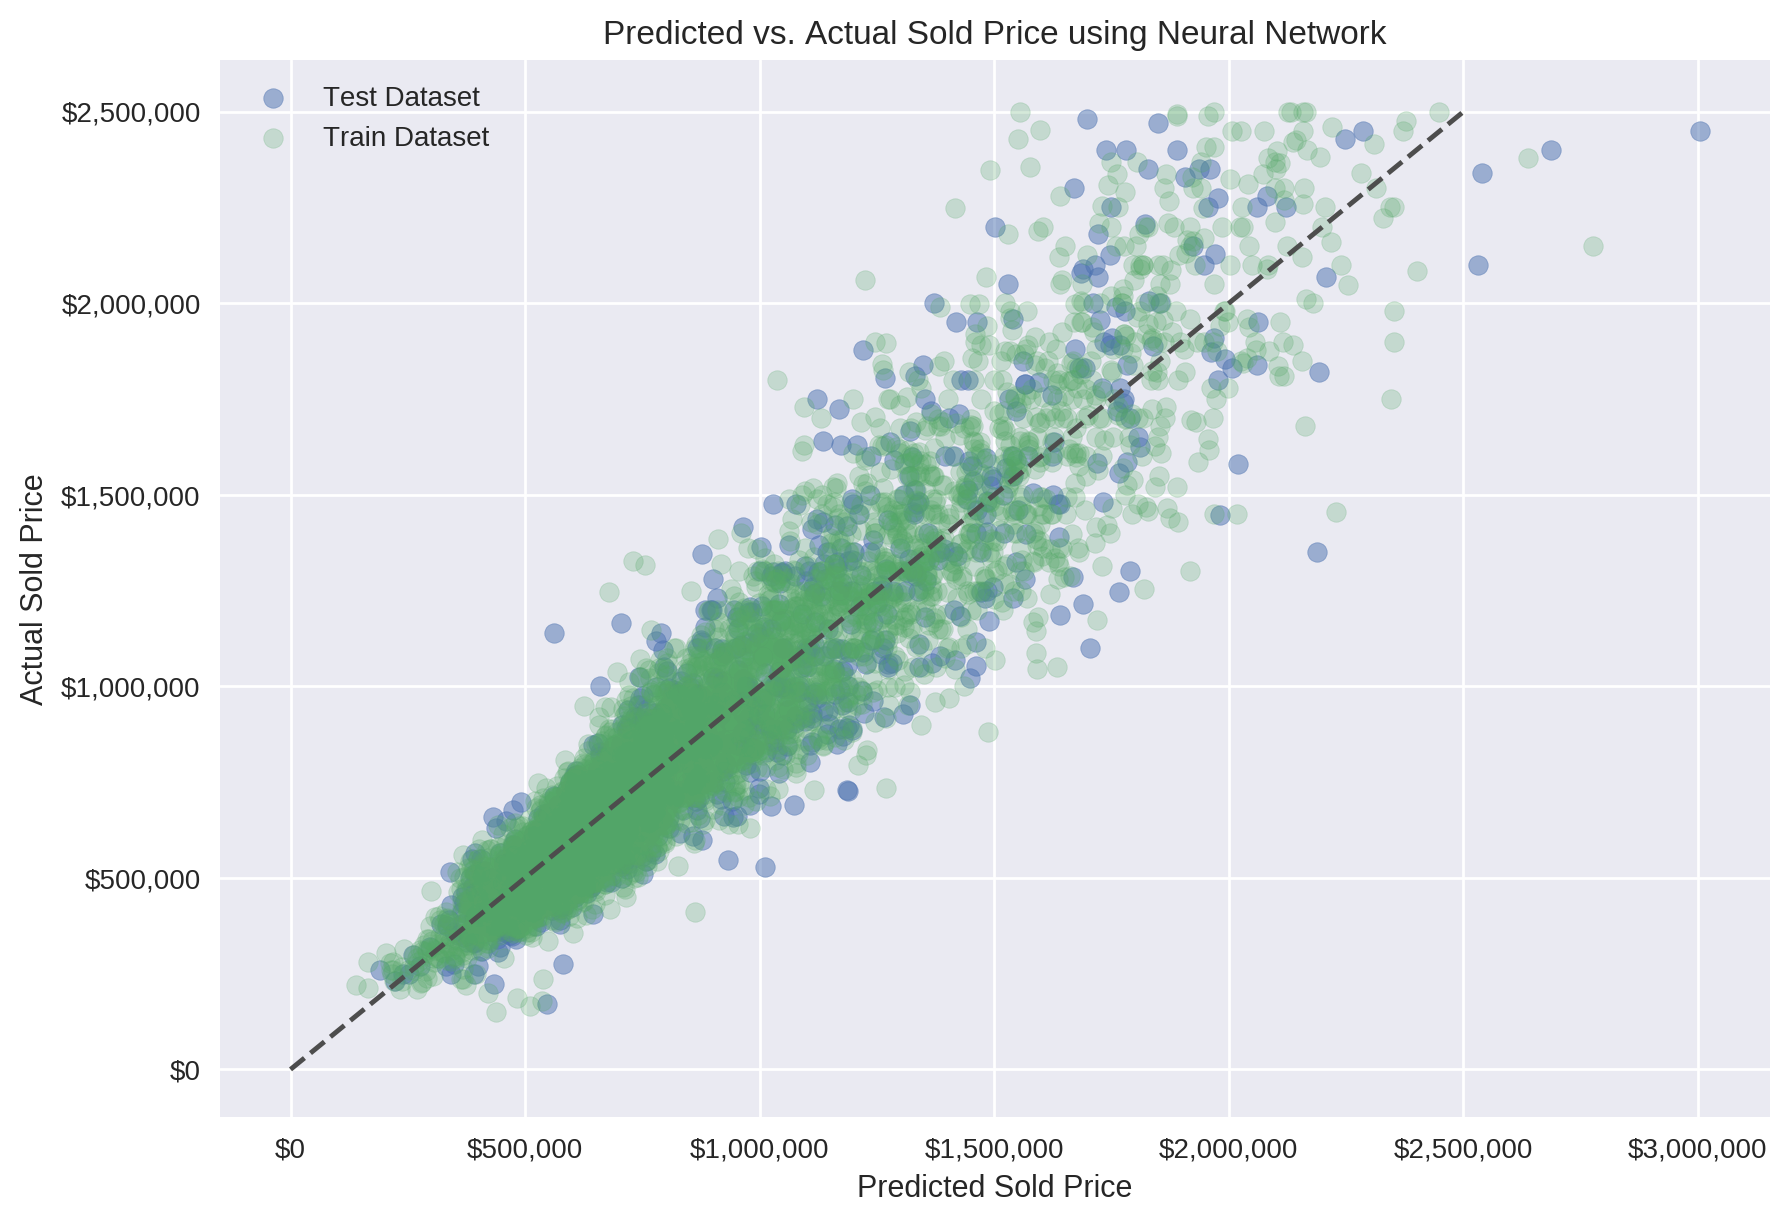

In [12]:
actual_train = denorm_sold_price(X_train, y_train, scaler)
predicted_train = denorm_sold_price(X_train, model.predict(X_train), scaler)
actual_test = denorm_sold_price(X_test, y_test, scaler)
predicted_test = denorm_sold_price(X_test, model.predict(X_test), scaler)

plt.figure(figsize=(10, 7), dpi=200, facecolor='w', edgecolor='k', )
plt.scatter(predicted_test, actual_test, alpha=0.5, label='Test Dataset')
plt.scatter(predicted_train, actual_train, alpha=0.25, label='Train Dataset')
plt.plot([0, 2500000], [0, 2500000], ls="--", c=".3")
plt.legend()
plt.xlabel("Predicted Sold Price")
plt.ylabel("Actual Sold Price")
plt.title("Predicted vs. Actual Sold Price using Neural Network")

plt.gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

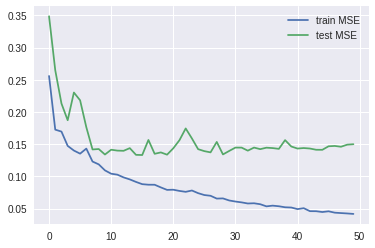

In [78]:
plt.plot(training.history['loss'], label='train MSE')
plt.plot(training.history['val_loss'], label='test MSE')
plt.legend()

In [104]:
regressor = KerasRegressor(build_fn=NN1, epochs=10, shuffle=True, verbose=0)
regressor.fit(X_train.values, y_train.values)

In [105]:
output_metrics(X_train.values, y_train.values, X_test.values, y_test.values, regressor, method, cv=5)

Neural Network R-squared for train: 0.8991
Neural Network R-squared for CV: 0.7873
Neural Network MSE for train: 0.1005
Neural Network MSE for CV: 0.1609
Neural Network MSE_CV/MSE_train: 1.6005

Neural Network R-squared for test: 0.8544
Neural Network MSE for test: 0.1478


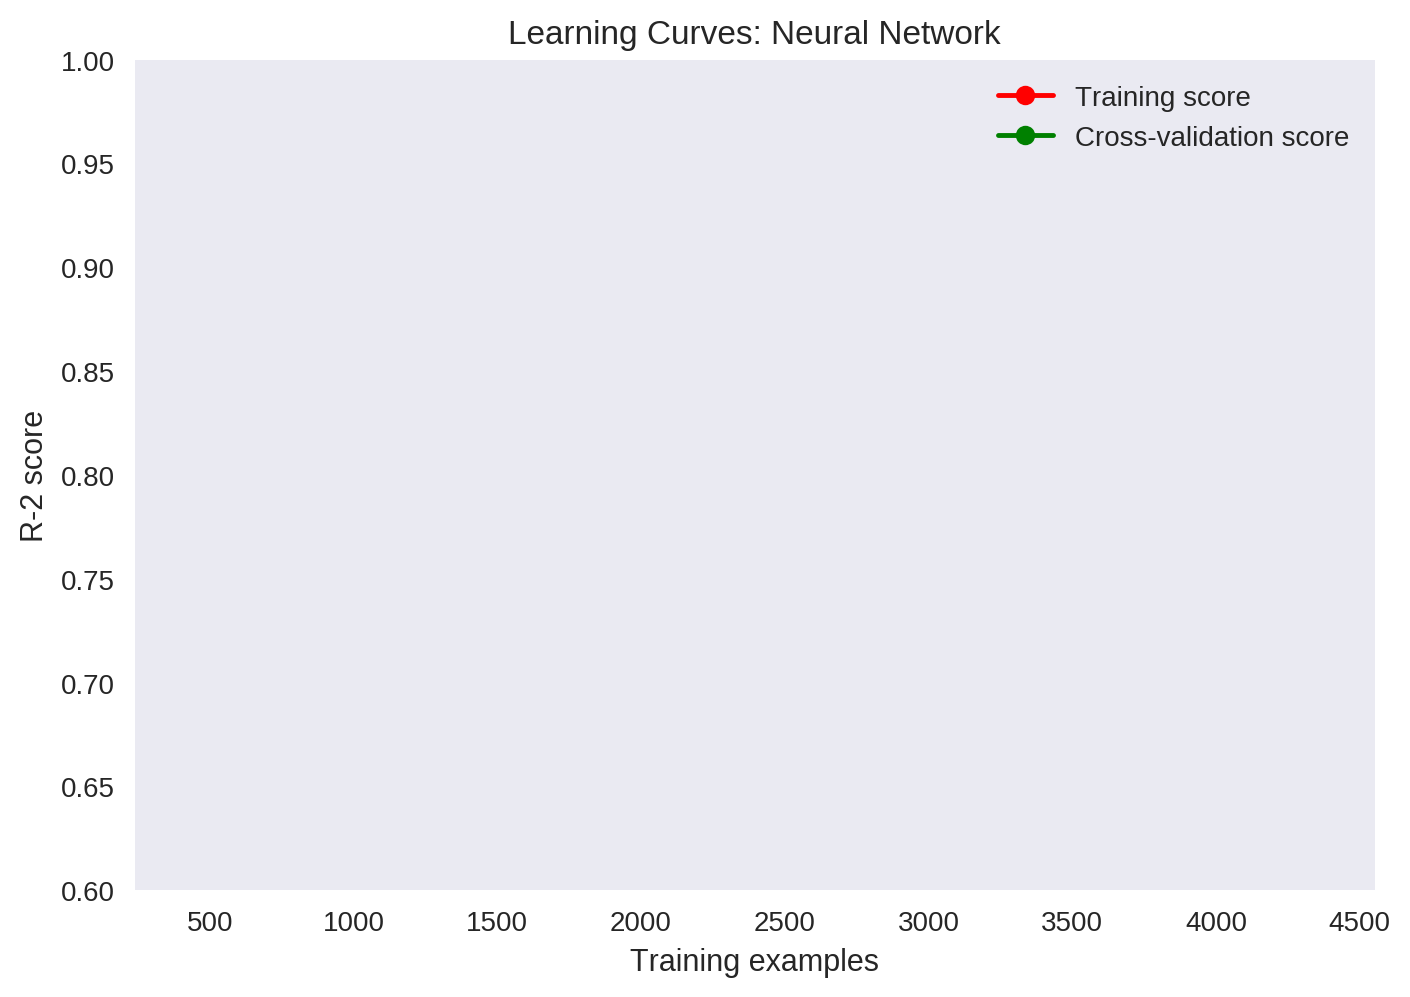

In [112]:
title = "Learning Curves: {method}".format(method=method)
plot_learning_curve(regressor, title, X_train.values, y_train.values, cv=5, ylim=(0.6, 1), figsize=(8, 5.5))
plt.show()

In [0]:
def run_model(nn_model):
    model = KerasRegressor(build_fn=nn_model, epochs=10, shuffle=True, verbose=0)
    model.fit(X_train.values, y_train.values)
    output_metrics(X_train.values, y_train.values, X_test.values, y_test.values, model, method, cv=cv)

In [122]:
run_model(NN2)

Neural Network R-squared for train: 0.8930
Neural Network R-squared for CV: 0.8089
Neural Network MSE for train: 0.1066
Neural Network MSE for CV: 0.1665
Neural Network MSE_CV/MSE_train: 1.5612

Neural Network R-squared for test: 0.8536
Neural Network MSE for test: 0.1486


In [123]:
run_model(NN3)

Neural Network R-squared for train: 0.8502
Neural Network R-squared for CV: 0.8180
Neural Network MSE for train: 0.1492
Neural Network MSE for CV: 0.1995
Neural Network MSE_CV/MSE_train: 1.3370

Neural Network R-squared for test: 0.8343
Neural Network MSE for test: 0.1682


In [126]:
run_model(NN4)

Neural Network R-squared for train: 0.8712
Neural Network R-squared for CV: 0.7594
Neural Network MSE for train: 0.1284
Neural Network MSE for CV: 0.2488
Neural Network MSE_CV/MSE_train: 1.9388

Neural Network R-squared for test: 0.8551
Neural Network MSE for test: 0.1471


In [131]:
run_model(NN5)

Neural Network R-squared for train: 0.8470
Neural Network R-squared for CV: 0.8278
Neural Network MSE for train: 0.1525
Neural Network MSE for CV: 0.1750
Neural Network MSE_CV/MSE_train: 1.1480

Neural Network R-squared for test: 0.8325
Neural Network MSE for test: 0.1699


In [132]:
run_model(NN6)

Neural Network R-squared for train: 0.8814
Neural Network R-squared for CV: 0.8280
Neural Network MSE for train: 0.1181
Neural Network MSE for CV: 0.2010
Neural Network MSE_CV/MSE_train: 1.7012

Neural Network R-squared for test: 0.8458
Neural Network MSE for test: 0.1565


In [15]:
scaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}